In [1]:
!pip install git+https://github.com/waltsims/k-wave-python

  Cloning https://github.com/waltsims/k-wave-python to /tmp/pip-req-build-odnelj38
  Running command git clone --filter=blob:none --quiet https://github.com/waltsims/k-wave-python /tmp/pip-req-build-odnelj38
  Resolved https://github.com/waltsims/k-wave-python to commit 493816bb5564426577bd56c374097196dafc75a0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 11.9 MB/s 

In [2]:
import numpy as np
from copy import deepcopy
import requests
import shutil

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.colors import Normalize
import matplotlib.cm as cm

from cycler import cycler

import h5py

from skimage import measure
from skimage.segmentation import find_boundaries
from scipy.interpolate import interpn

from kwave.data import Vector
from kwave.utils.kwave_array import kWaveArray
from kwave.utils.checks import check_stability
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksource import kSource
from kwave.ksensor import kSensor
from kwave.utils.signals import create_cw_signals
from kwave.utils.filters import extract_amp_phase
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3DG

from kwave.options.simulation_options import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions

verbose: bool = True
savePlotting: bool = False
useMaxTimeStep: bool = True

tag = 'bm7'
res = '1mm'

mask_filename = 'skull_mask_' + tag + '_dx_' + res + '.mat'

url = 'https://raw.githubusercontent.com/djps/k-wave-python/benchmarks/examples/benchmarks/7/skull_mask_bm7_dx_1mm.mat'
mask_filename = requests.get(url, stream=True)
mask_filename.raw.decode_content = True
with open("temp.h5", "wb") as _fh:
    shutil.copyfileobj(mask_filename.raw, _fh)
data = h5py.File("temp.h5", mode='r')

# is given in millimetres
dx = data['dx'][:].item()

# scale to metres
dx = dx / 1000.0
dy = dx
dz = dx

xi = np.squeeze(np.asarray(data['xi'][:]))
yi = np.squeeze(np.asarray(data['yi'][:]))
zi = np.squeeze(np.asarray(data['zi'][:]))

matlab_shape = np.shape(xi)[0], np.shape(yi)[0], np.shape(zi)[0]

skull_mask = np.squeeze(data['skull_mask'][:]).astype(bool)
brain_mask = np.squeeze(data['brain_mask'][:]).astype(bool)

skull_mask = np.reshape(skull_mask.flatten(), matlab_shape, order='F')
brain_mask = np.reshape(brain_mask.flatten(), matlab_shape, order='F')

water_mask = np.ones(skull_mask.shape, dtype=int) - (skull_mask.astype(int) + brain_mask.astype(int))
water_mask = water_mask.astype(bool)

skull_mask = np.swapaxes(skull_mask, 0, 2)
brain_mask = np.swapaxes(brain_mask, 0, 2)
water_mask = np.swapaxes(water_mask, 0, 2)

Nx, Ny, Nz = skull_mask.shape

focus = int(64 / data['dx'][:].item())

focus_coords = [(Nx - 1) // 2, (Ny - 1) // 2, focus]

bowl_coords = [(Nx - 1) // 2, (Ny - 1) // 2, 0]

In [3]:
# =========================================================================
# DEFINE THE MATERIAL PROPERTIES
# =========================================================================

# water
sound_speed = 1500.0 * np.ones(skull_mask.shape)
density = 1000.0 * np.ones(skull_mask.shape)
alpha_coeff = np.zeros(skull_mask.shape)

# non-dispersive
alpha_power = 2.0

# skull
sound_speed[skull_mask] = 2800.0
density[skull_mask] = 1850.0
alpha_coeff[skull_mask] = 4.0

# brain
sound_speed[brain_mask] = 1560.0
density[brain_mask] = 1040.0
alpha_coeff[brain_mask] = 0.3

c0_min = np.min(np.ravel(sound_speed))
c0_max = np.min(np.ravel(sound_speed))

medium = kWaveMedium(sound_speed=sound_speed,
                     density=density,
                     alpha_coeff=alpha_coeff,
                     alpha_power=alpha_power)

In [4]:
# =========================================================================
# DEFINE THE TRANSDUCER SETUP
# =========================================================================

# bowl radius of curvature [m]
source_roc: float = 64.0e-3

# as we will use the bowl element this has to be a int or float
diameters: float = 64.0e-3

# frequency [Hz]
freq: float = 500e3

# source pressure [Pa]
source_amp = np.array([60e3])

# phase [rad]
source_phase = np.array([0.0])

In [5]:
# =========================================================================
# DEFINE COMPUTATIONAL PARAMETERS
# =========================================================================

# wavelength
k_min: float = c0_min / freq

# points per wavelength
ppw: float = k_min / dx

# number of periods to record
record_periods: int = 3

# compute points per period
ppp: int = 30

# CFL number determines time step
cfl: float = (ppw / ppp)

In [6]:
# =========================================================================
# DEFINE THE KGRID
# =========================================================================

grid_size_points = Vector([Nx, Ny, Nz])

grid_spacing_meters = Vector([dx, dy, dz])

# create the k-space grid
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)

In [7]:
# =========================================================================
# DEFINE THE TIME VECTOR
# =========================================================================

# compute corresponding time stepping
dt = 1.0 / (ppp * freq)

# compute corresponding time stepping
dt = (c0_min / c0_max) / (float(ppp) * freq)

dt_stability_limit = check_stability(kgrid, medium)

if (useMaxTimeStep and (not np.isfinite(dt_stability_limit)) and (dt_stability_limit < dt)):
    dt_old = dt
    ppp = np.ceil(1.0 / (dt_stability_limit * freq))
    dt = 1.0 / (ppp * freq)

# calculate the number of time steps to reach steady state
t_end = np.sqrt(kgrid.x_size**2 + kgrid.y_size**2) / c0_min

# create the time array using an integer number of points per period
Nt = round(t_end / dt)

# make time array
kgrid.setTime(Nt, dt)

# calculate the actual CFL after adjusting for dt
cfl_actual = 1.0 / (dt * freq)

In [9]:
# =========================================================================
# DEFINE THE SOURCE PARAMETERS
# =========================================================================

# create empty kWaveArray this specfies the transducer properties
karray = kWaveArray(bli_tolerance=0.01,
                    upsampling_rate=16,
                    single_precision=True)

# set bowl position and orientation
bowl_pos = [kgrid.x_vec[bowl_coords[0]].item(),
            kgrid.y_vec[bowl_coords[1]].item(),
            kgrid.z_vec[bowl_coords[2]].item()]

focus_pos = [kgrid.x_vec[focus_coords[0]].item(),
             kgrid.y_vec[focus_coords[1]].item(),
             kgrid.z_vec[focus_coords[2]].item()]

# add bowl shaped element
karray.add_bowl_element(bowl_pos, source_roc, diameters, focus_pos)

# create time varying source
source_sig = create_cw_signals(np.squeeze(kgrid.t_array),
                               freq,
                               source_amp,
                               source_phase)

# make a source object.
source = kSource()

# assign binary mask using the karray
source.p_mask = karray.get_array_binary_mask(kgrid)

# assign source pressure output in time
source.p = karray.get_distributed_source_signal(kgrid, source_sig)

# tx_pos = karray.get_element_nodes(kgrid)
# tx_mask = np.empty((skull_mask.shape), dtype=float)
# tx_mask.fill(0.0)
# for ind in np.arange(np.shape(tx_pos)[1]):
#     i = int((tx_pos[0, ind] - kgrid.x_vec[0]) / kgrid.dx)
#     j = int((tx_pos[1, ind] - kgrid.y_vec[0]) / kgrid.dy)
#     k = int((tx_pos[2, ind] - kgrid.z_vec[0]) / kgrid.dz)
#     if ((i >= 0) and (j >= 0) and (k >= 0) and (i < kgrid.Nx) and (j < kgrid.Ny) and (k < kgrid.Nz)):
#         tx_mask[i, j, k] = 1.0

In [10]:
# =========================================================================
# DEFINE THE SENSOR PARAMETERS
# =========================================================================

sensor = kSensor()

# set sensor mask: the mask says at which points data should be recorded
sensor.mask = np.ones((Nx, Ny, Nz), dtype=bool)

# set the record type: record the pressure waveform
sensor.record = ['p']

# record the final few periods when the field is in steady state
sensor.record_start_index = kgrid.Nt - (record_periods * ppp) + 1

In [11]:
# =========================================================================
# DEFINE THE SIMULATION PARAMETERS
# =========================================================================

DATA_CAST = 'single'
DATA_PATH = '.'

input_filename = tag + '_' + res + '_input.h5'
output_filename = tag + '_' + res + '_output.h5'

# options for writing to file, but not doing simulations
simulation_options = SimulationOptions(
    data_cast=DATA_CAST,
    data_recast=True,
    save_to_disk=True,
    input_filename=input_filename,
    output_filename=output_filename,
    save_to_disk_exit=False,
    data_path=DATA_PATH,
    pml_inside=False)

execution_options = SimulationExecutionOptions(
    is_gpu_simulation=True,
    delete_data=False,
    verbose_level=2)

In [13]:
# =========================================================================
# RUN THE SIMULATION
# =========================================================================

sensor_data = kspaceFirstOrder3DG(
    medium=medium,
    kgrid=deepcopy(kgrid),
    source=source,
    sensor=sensor,
    simulation_options=simulation_options,
    execution_options=execution_options)

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Git hash:            468dc31c2842a7df5f2a07c3a13c16c9b0b2b770 │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ File format version:                                      1.2 │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                              91 x 91 x 141 │
│ Medium t

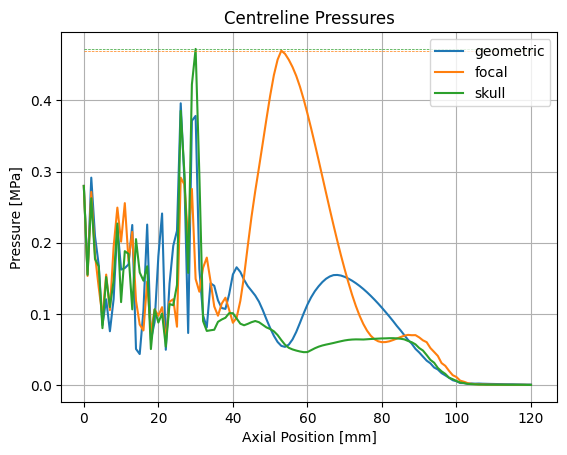

In [14]:
# =========================================================================
# POST-PROCESS
# =========================================================================

# sampling frequency
fs = 1.0 / kgrid.dt

# get Fourier coefficients
amp, _, _ = extract_amp_phase(sensor_data['p'].T, fs, freq, dim=1,
                              fft_padding=1, window='Rectangular')

# reshape data: matlab uses Fortran ordering
p = np.reshape(amp, (Nx, Ny, Nz), order='F')
pmax = np.nanmax(p)
max_loc = np.unravel_index(np.nanargmax(p), p.shape, order='C')

p_water = np.empty_like(p)
p_water.fill(np.nan)
p_water[water_mask] = p[water_mask]
pmax_water = np.nanmax(p_water)
max_loc_water = np.unravel_index(np.nanargmax(p_water), p.shape, order='C')

p_skull = np.empty_like(p)
p_skull.fill(np.nan)
p_skull[skull_mask] = p[skull_mask]
pmax_skull = np.nanmax(p_skull)
max_loc_skull = np.unravel_index(np.nanargmax(p_skull), p.shape, order='C')

p_brain = np.empty_like(p)
p_brain.fill(np.nan)
p_brain[brain_mask] = p[brain_mask]
pmax_brain = np.nanmax(p_brain)
max_loc_brain = np.unravel_index(np.nanargmax(p_brain), p.shape, order='C')

# domain axes
x_vec = np.linspace(kgrid.x_vec[0].item(), kgrid.x_vec[-1].item(), kgrid.Nx)
y_vec = np.linspace(kgrid.y_vec[0].item(), kgrid.y_vec[-1].item(), kgrid.Ny)
z_vec = np.linspace(kgrid.z_vec[0].item(), kgrid.z_vec[-1].item(), kgrid.Nz)

# colours
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# brain axes
# x
x_x_brain = [kgrid.z_vec[bowl_coords[2]].item(), kgrid.z_vec[max_loc_brain[2]].item()]
y_x_brain = [kgrid.x_vec[bowl_coords[0]].item(), kgrid.x_vec[max_loc_brain[0]].item()]
coefficients_x_brain = np.polyfit(x_x_brain, y_x_brain, 1)
polynomial_x_brain = np.poly1d(coefficients_x_brain)
beam_axis_x_brain = polynomial_x_brain(z_vec)

# y
x_y_brain = [kgrid.z_vec[bowl_coords[2]].item(), kgrid.z_vec[max_loc_brain[2]].item()]
y_y_brain = [kgrid.y_vec[bowl_coords[1]].item(), kgrid.y_vec[max_loc_brain[1]].item()]
coefficients_y_brain = np.polyfit(x_y_brain, y_y_brain, 1)
polynomial_y_brain = np.poly1d(coefficients_y_brain)
beam_axis_y_brain = polynomial_y_brain(z_vec)

# beam axis
beam_axis_brain = np.vstack((beam_axis_x_brain, beam_axis_y_brain, z_vec)).T

# interpolate for pressure on brain axis
beam_pressure_brain = interpn((x_vec, y_vec, z_vec), p, beam_axis_brain,
                              method='linear', bounds_error=False, fill_value=np.nan)

# skull axes
# x
x_x_skull = [kgrid.z_vec[bowl_coords[2]].item(), kgrid.z_vec[max_loc_skull[2]].item()]
y_x_skull = [kgrid.x_vec[bowl_coords[0]].item(), kgrid.x_vec[max_loc_skull[0]].item()]
coefficients_x_skull = np.polyfit(x_x_skull, y_x_skull, 1)
polynomial_x_skull = np.poly1d(coefficients_x_skull)
beam_axis_x_skull = polynomial_x_skull(z_vec)

# y
x_y_skull = [kgrid.z_vec[bowl_coords[2]].item(), kgrid.z_vec[max_loc_skull[2]].item()]
y_y_skull = [kgrid.y_vec[bowl_coords[1]].item(), kgrid.y_vec[max_loc_skull[1]].item()]
coefficients_y_skull = np.polyfit(x_y_skull, y_y_skull, 1)
polynomial_y_skull = np.poly1d(coefficients_y_skull)
beam_axis_y_skull = polynomial_y_skull(z_vec)

# beam axis
beam_axis_skull = np.vstack((beam_axis_x_skull, beam_axis_y_skull, z_vec)).T

# interpolate for pressure
beam_pressure_skull = interpn((x_vec, y_vec, z_vec), p, beam_axis_skull,
                              method='linear', bounds_error=False,
                              fill_value=np.nan)

# plot pressure on through centre lines
fig1, ax1 = plt.subplots()
ax1.plot(p[(Nx - 1) // 2, (Ny - 1) // 2, :] / 1e6, label='geometric')
ax1.plot(beam_pressure_brain / 1e6, label='focal')
ax1.plot(beam_pressure_skull / 1e6, label='skull')
ax1.hlines(pmax_brain / 1e6, 0, len(z_vec), color=cycle[1], linestyle='dashed', lw=0.5)
ax1.hlines(pmax_skull / 1e6, 0, len(z_vec), color=cycle[2], linestyle='dashed', lw=0.5)
ax1.set(xlabel='Axial Position [mm]',
        ylabel='Pressure [MPa]',
        title='Centreline Pressures')
ax1.legend()
ax1.grid(True)

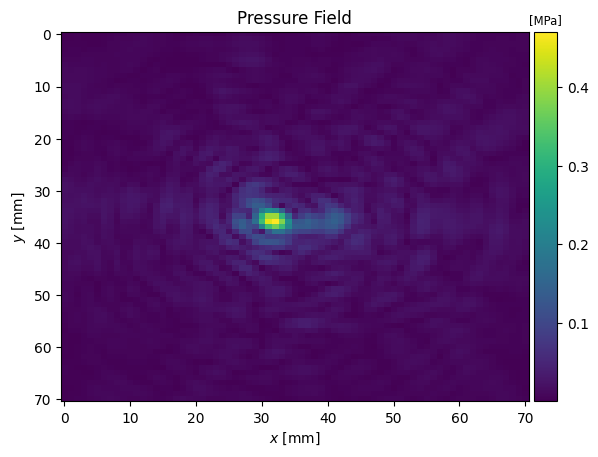

In [21]:
def get_edges(mask, fill_with_nan=True):
    """returns the mask as a float array and Np.NaN"""
    edges = find_boundaries(mask, mode='thin').astype(np.float32)
    if fill_with_nan:
        edges[edges == 0] = np.nan
    return edges


# contouring block
edges_x = get_edges(np.transpose(skull_mask[max_loc_brain[0], :, :]).astype(int),
                    fill_with_nan=False)
edges_y = get_edges(np.transpose(skull_mask[:, max_loc_brain[1], :]).astype(int),
                    fill_with_nan=False)
edges_z = get_edges(np.transpose(skull_mask[:, :, max_loc_brain[2]]).astype(int),
                    fill_with_nan=False)

contour_x, num_x = measure.label(edges_x, background=0, return_num=True, connectivity=2)
contour_y, num_y = measure.label(edges_y, background=0, return_num=True, connectivity=2)
contour_z, num_z = measure.label(edges_z, background=0, return_num=True, connectivity=2)

jmax = 0
jmin = Ny
i_inner = None
i_outer = None
for i in range(num_x):
    j = np.argmax(np.where(contour_x[:, Nz // 2] == (i + 1), 1, 0))
    if (j > jmax):
        jmax = j
        i_outer = i + 1
    k = np.argmin(np.where(contour_x[:, Nz // 2] == (i + 1), 0, 1))
    if (k < jmin):
        jmin = k
        i_inner = i + 1
contours_x_inner = measure.find_contours(np.where(contour_x == i_inner, 1, 0))
if not contours_x_inner:
    print("size of contours_x_inner is zero")
contours_x_outer = measure.find_contours(np.where(contour_x == i_outer, 1, 0))
if not contours_x_outer:
   print("size of contours_x_outer is zero")
inner_index_x = float(Ny)
outer_index_x = float(0)
for i in range(len(contours_x_inner)):
    x_min = np.min(contours_x_inner[i][:, 1])
    if (x_min < inner_index_x):
        inner_index_x = i
for i in range(len(contours_x_outer)):
    x_max = np.max(contours_x_outer[i][:, 1])
    if (x_max > outer_index_x):
        outer_index_x = i

jmax = 0
jmin = Nx
i_inner = None
i_outer = None
for i in range(num_y):
    j = np.argmax(np.where(contour_y[:, Nz // 2] == (i + 1), 1, 0))
    if (j > jmax):
        jmax = j
        i_outer = i + 1
    k = np.argmin(np.where(contour_y[:, Nz // 2] == (i + 1), 0, 1))
    if (k < jmin):
        jmin = k
        i_inner = i + 1
contours_y_inner = measure.find_contours(np.where(contour_y == i_inner, 1, 0))
if not contours_y_inner:
    print("size of contours_y_inner is zero")
contours_y_outer = measure.find_contours(np.where(contour_y == i_outer, 1, 0))
if not contours_y_outer:
    print("size of contours_y_outer is zero")
inner_index_y = float(Nx)
outer_index_y = float(0)
for i in range(len(contours_y_inner)):
    y_min = np.min(contours_y_inner[i][:, 1])
    if (y_min < inner_index_y):
        inner_index_y = i
for i in range(len(contours_y_outer)):
    y_max = np.max(contours_y_outer[i][:, 1])
    if (y_max > outer_index_y):
        outer_index_y = i

jmax = 0
jmin = Ny
i_inner = None
i_outer = None
for i in range(num_z):
    j = np.argmax(np.where(contour_z[:, Nx // 2] == (i + 1), 1, 0))
    if (j > jmax):
        jmax = j
        i_outer = i + 1
    k = np.argmin(np.where(contour_z[:, Nx // 2] == (i + 1), 0, 1))
    if (k < jmin):
        jmin = k
        i_inner = i + 1

contours_z_inner = measure.find_contours(np.where(contour_z == i_inner, 1, 0))
if not contours_z_inner:
    pass
else:
    inner_index_z = float(Nx)
    for i in range(len(contours_z_inner)):
        z_min = np.min(contours_z_inner[i][:, 1])
        if (z_min < inner_index_z):
            inner_index_z = i

contours_z_outer = measure.find_contours(np.where(contour_z == i_outer, 1, 0))
if not contours_z_outer:
    pass
else:
    outer_index_z = float(0)
    for i in range(len(contours_z_outer)):
        z_max = np.max(contours_z_outer[i][:, 1])
        if (z_max > outer_index_z):
            outer_index_z = i

# end of contouring block
edges_x = get_edges(np.transpose(skull_mask[max_loc_brain[0], :, :]).astype(int))
edges_y = get_edges(np.transpose(skull_mask[:, max_loc_brain[1], :]).astype(int))
edges_z = get_edges(np.transpose(skull_mask[:, :, max_loc_brain[2]]).astype(int))

# plot the pressure field at mid point along z axis
fig2, ax2 = plt.subplots()
im2 = ax2.imshow(p[:, :, max_loc_brain[2]] / 1e6,
                 aspect='auto',
                 interpolation='none',
                 origin='lower',
                 cmap='viridis')

if not contours_z_inner:
    ax2.imshow(edges_z, aspect='auto', interpolation='none',
               cmap='Greys', origin='upper')
else:
    ax2.plot(contours_z_inner[inner_index_z][:, 1],
             contours_z_inner[inner_index_z][:, 0], 'w', linewidth=0.5)
if not contours_z_outer:
    pass
else:
    ax2.plot(contours_z_outer[outer_index_z][:, 1],
             contours_z_outer[outer_index_z][:, 0], 'w', linewidth=0.5)
#
ax2.set(xlabel=r'$x$ [mm]',
        ylabel=r'$y$ [mm]',
        title='Pressure Field')
ax2.grid(False)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar_2 = fig2.colorbar(im2, cax=cax2)
cbar_2.ax.set_title('[MPa]', fontsize='small')

pwater_max_x = np.nanmax(p_water[max_loc_brain[0], :, :].flatten())
pskull_max_x = np.nanmax(p_skull[max_loc_brain[0], :, :].flatten())
pbrain_max_x = np.nanmax(p_brain[max_loc_brain[0], :, :].flatten())

pwater_max_y = np.nanmax(p_water[:, max_loc_brain[1], :].flatten())
pskull_max_y = np.nanmax(p_skull[:, max_loc_brain[1], :].flatten())
pbrain_max_y = np.nanmax(p_brain[:, max_loc_brain[1], :].flatten())

px_vec = np.linspace(kgrid.x_vec[0].item() - kgrid.dx,
                     kgrid.x_vec[-1].item() + kgrid.dx, kgrid.Nx + 1)
py_vec = np.linspace(kgrid.y_vec[0].item() - kgrid.dy,
                     kgrid.y_vec[-1].item() + kgrid.dy, kgrid.Ny + 1)
pz_vec = np.linspace(kgrid.z_vec[0].item() - kgrid.dz,
                     kgrid.z_vec[-1].item() + kgrid.dz, kgrid.Nz + 1)

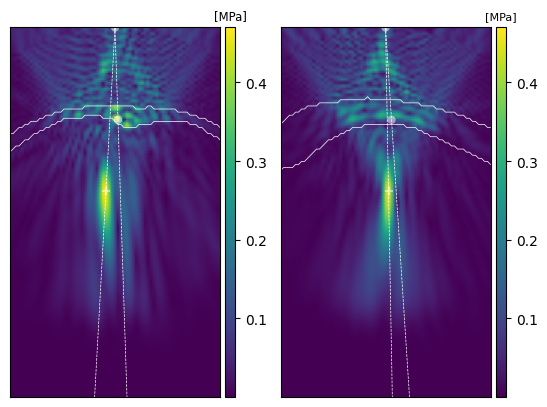

In [16]:
fig3, (ax3a, ax3b) = plt.subplots(1, 2)
im3a = ax3a.pcolormesh(y_vec, z_vec, p[max_loc_brain[0], :, :].T / 1e6,
                       shading='gouraud', cmap='viridis')

ax3a.plot(beam_axis_y_skull, z_vec, 'w--', lw=0.5)
ax3a.plot(beam_axis_y_brain, z_vec, 'w--', lw=0.5)

# reversed and new underscore
ax3a.scatter(y_y_skull, x_y_skull, c='w', marker='o', edgecolors='none', alpha=0.5)
ax3a.scatter(y_y_brain, x_y_brain, c='w', marker='+', alpha=0.5)

# ------------------------------------------------------------------------------
ax3a.plot(contours_x_inner[outer_index_x][:, 1] * kgrid.dy + kgrid.y_vec[0],
          contours_x_inner[outer_index_x][:, 0] * kgrid.dz + kgrid.z_vec[0],
          'w', linewidth=0.5)
ax3a.plot(contours_x_outer[inner_index_x][:, 1] * kgrid.dy + kgrid.y_vec[0],
          contours_x_outer[inner_index_x][:, 0] * kgrid.dz + kgrid.z_vec[0],
          'w', linewidth=0.5)
# ------------------------------------------------------------------------------
ax3a.grid(False)
ax3a.axes.get_yaxis().set_visible(False)
ax3a.axes.get_xaxis().set_visible(False)
divider3a = make_axes_locatable(ax3a)
cax3a = divider3a.append_axes("right", size="5%", pad=0.05)
cbar_3a = fig3.colorbar(im3a, cax=cax3a)
cbar_3a.ax.set_title('[MPa]', fontsize='small')

ax3a.invert_yaxis()

im3b = ax3b.pcolormesh(x_vec, z_vec, p[:, max_loc_brain[1], :].T / 1e6,
                       shading='gouraud', cmap='viridis')

# ------------------------------------------------------------------------------
ax3b.plot(contours_y_inner[inner_index_y][:, 1] * kgrid.dx + kgrid.x_vec[0],
          contours_y_inner[inner_index_y][:, 0] * kgrid.dz + kgrid.z_vec[0],
          'w', linewidth=0.5)
ax3b.plot(contours_y_outer[outer_index_y][:, 1] * kgrid.dx + kgrid.x_vec[0],
          contours_y_outer[outer_index_y][:, 0] * kgrid.dz + kgrid.z_vec[0],
          'w', linewidth=0.5)

ax3b.plot(beam_axis_x_skull, z_vec, 'w--', lw=0.5)
ax3b.plot(beam_axis_x_brain, z_vec, 'w--', lw=0.5)
ax3b.scatter(y_x_skull, x_x_skull, c='w', marker='o', edgecolors='none', alpha=0.5)
ax3b.scatter(y_x_brain, x_x_brain, c='w', marker='+', alpha=0.5)

# ------------------------------------------------------------------------------
ax3b.grid(False)
ax3b.axes.get_yaxis().set_visible(False)
ax3b.axes.get_xaxis().set_visible(False)
divider3b = make_axes_locatable(ax3b)
cax3b = divider3b.append_axes("right", size="5%", pad=0.05)
cbar_3b = fig3.colorbar(im3b, cax=cax3b)
cbar_3b.ax.set_title('[MPa]', fontdict={'fontsize': 8})
ax3b.invert_yaxis()

Text(0.5, 1.0, '[MPa]')

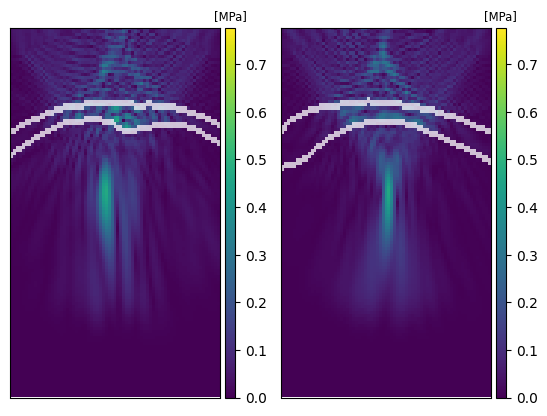

In [18]:
fig5, (ax5a, ax5b) = plt.subplots(1, 2)
im5a = ax5a.imshow(p[max_loc_brain[0], :, :].T / 1e6,
                   vmin=0, vmax=pmax / 1e6,
                   aspect='auto',
                   interpolation='none',
                   origin='upper',
                   cmap='viridis')
im5a_boundary = ax5a.imshow(edges_x, aspect='auto', interpolation='none',
                            cmap='Greys', origin='upper', alpha=0.75)
ax5a.grid(False)
ax5a.axes.get_yaxis().set_visible(False)
ax5a.axes.get_xaxis().set_visible(False)
divider5a = make_axes_locatable(ax5a)
cax5a = divider5a.append_axes("right", size="5%", pad=0.05)
cbar_5a = fig5.colorbar(im5a, cax=cax5a)
cbar_5a.ax.set_title('[MPa]', fontsize='small')
im5b = ax5b.imshow(p[:, max_loc_brain[1], :].T / 1e6,
                   vmin=0, vmax=pmax / 1e6,
                   aspect='auto',
                   interpolation='none',
                   origin='upper',
                   cmap='viridis')
im5b_boundary = ax5b.imshow(edges_y, aspect='auto', interpolation='none',
                            cmap='Greys', origin='upper', alpha=0.75)
ax5b.grid(False)
ax5b.axes.get_yaxis().set_visible(False)
ax5b.axes.get_xaxis().set_visible(False)
divider5b = make_axes_locatable(ax5b)
cax5b = divider5b.append_axes("right", size="5%", pad=0.05)
cbar_5b = fig5.colorbar(im5b, cax=cax5b)
cbar_5b.ax.set_title('[MPa]', fontsize='small')

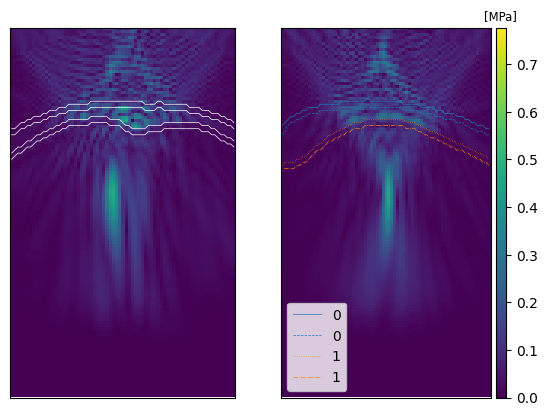

In [19]:
all_contours_x = []
for i in range(num_x):
    all_contours_x.append(measure.find_contours(np.where(contour_x == (i + 1), 1, 0)))

all_contours_y = []
for i in range(num_y):
    all_contours_y.append(measure.find_contours(np.where(contour_y == (i + 1), 1, 0)))

fig6, (ax6a, ax6b) = plt.subplots(1, 2)
im6a = ax6a.imshow(p[max_loc_brain[0], :, :].T / 1e6,
                   vmin=0, vmax=pmax / 1e6,
                   aspect='auto',
                   interpolation='none',
                   origin='upper',
                   cmap='viridis')
for contour in all_contours_x:
    for i in range(len(contour)):
        ax6a.plot(contour[i][:, 1], contour[i][:, 0], 'w', linewidth=0.5)
ax6a.grid(False)
ax6a.axes.get_yaxis().set_visible(False)
ax6a.axes.get_xaxis().set_visible(False)
divider6a = make_axes_locatable(ax5a)
cax6a = divider6a.append_axes("right", size="5%", pad=0.05)
cbar_6a = fig6.colorbar(im6a, cax=cax6a)
cbar_6a.ax.set_title('[MPa]', fontsize='small')
im6b = ax6b.imshow(p[:, max_loc_brain[1], :].T / 1e6,
                   vmin=0, vmax=pmax / 1e6,
                   aspect='auto',
                   interpolation='none',
                   origin='upper',
                   cmap='viridis')

custom_cycler = cycler(ls=['-', '--', ':', '-.'])

ax6b.set_prop_cycle(custom_cycler)

for idx, contour in enumerate(all_contours_y):
    for i in range(len(contour)):
        ax6b.plot(contour[i][:, 1], contour[i][:, 0], c=cycle[idx],
                  linewidth=0.5, label=str(idx))
ax6b.legend()
ax6b.grid(False)
ax6b.axes.get_yaxis().set_visible(False)
ax6b.axes.get_xaxis().set_visible(False)
divider6b = make_axes_locatable(ax6b)
cax6b = divider6b.append_axes("right", size="5%", pad=0.05)
cbar_6b = fig6.colorbar(im6b, cax=cax6b)
cbar_6b.ax.set_title('[MPa]', fontsize='small')

plt.show()